<a href="https://colab.research.google.com/github/danhorsley/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

In [0]:
!pip install category_encoders 

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [6]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [3]:
train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [0]:
certain_features=['Facility Type','Risk','City','Inspection Type','Latitude','Longitude']
target = 'Fail'

In [10]:
#we can see this is a fairly unbalanced dataset with 75/25 split
#with this in behind all models would need to beat baseline prediction of majority class - i.e. 75%
train['Fail'].value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [108]:
#violations is clearly the leak as it contains descriptions of all the failings.  even just the nans gives you a huge lead as presumably
#many of the restaurants that passed had no failings
train[train['Violations'].isna()]['Fail'].value_counts()

0    8551
1    1104
Name: Fail, dtype: int64

In [83]:
#the leak could also have been in inspection type, but it's no where near as obvious.  will probably be a good feature though
train[train['Fail']==1]['Inspection Type'].value_counts(normalize=True)[:6]

Canvass                  0.466483
License                  0.237003
Complaint                0.158722
Canvass Re-Inspection    0.034560
License Re-Inspection    0.028750
Short Form Complaint     0.024579
Name: Inspection Type, dtype: float64

In [84]:
train[train['Fail']==0]['Inspection Type'].value_counts(normalize=True)[:6]

Canvass                    0.465250
Canvass Re-Inspection      0.152823
License                    0.120632
Complaint                  0.073190
License Re-Inspection      0.067967
Complaint Re-Inspection    0.052171
Name: Inspection Type, dtype: float64

In [0]:
train.isna().sum()

In [0]:
import numpy as np
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
preprocessor = make_pipeline(ce.OrdinalEncoder(),SimpleImputer(),RobustScaler())
features=['Facility Type','Risk','Inspection Type','Latitude','Longitude']
preprocessor.fit(train[features])

def process_data(frame):
  X=frame.copy()[features]
  X = preprocessor.transform(X)
  X=pd.DataFrame(X,columns=features)
  
  return X

In [50]:
X=process_data(train)
y=train.copy()[target]
X.head()

,Facility Type,Risk,Inspection Type,Latitude,Longitude
0,0.0,0.0,-0.25,0.443442,0.302263
1,1.0,1.0,0.00,-1.084272,-0.228675
2,0.0,0.0,0.25,-1.209939,1.254855
3,0.0,2.0,-0.25,-0.717306,-0.550151
4,2.0,0.0,-0.25,-0.095659,-0.133823


In [51]:
#no crazy correlations
check_correlations=X.copy()
check_correlations['target']=y
check_correlations.corr()

,Facility Type,Risk,Inspection Type,Latitude,Longitude,target
Facility Type,1.000000,0.066296,0.034760,-0.013658,0.014956,0.011775
Risk,0.066296,1.000000,0.089606,-0.114487,0.011291,0.019954
Inspection Type,0.034760,0.089606,1.000000,-0.046500,0.059140,0.084138
Latitude,-0.013658,-0.114487,-0.046500,1.000000,-0.430789,-0.014121
Longitude,0.014956,0.011291,0.059140,-0.430789,1.000000,0.015722
target,0.011775,0.019954,0.084138,-0.014121,0.015722,1.000000


In [67]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random

#first we can have a look at xgbclassifier on randomized search cv maximising for rocauc
param_distributions = {
    'n_estimators':randint(90,150),
    'max_depth':randint(2,5)}#,
   #  'booster': random.choice('gbtree', 'gblinear' ,'dart')}

search=RandomizedSearchCV(
      estimator=XGBClassifier(booster='dart',n_jobs=-1,random_state=42),
      param_distributions=param_distributions,
      n_iter=20,
      scoring='roc_auc',
      n_jobs=-1,
      cv=3,
      verbose=10,
      return_train_score=True)

search.fit(X,y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff88a18c2e8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff88a18c2b0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [55]:
#best combo was max depth 4 with 135 estimators followed by 134 estimators and 111 estimators
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
14,3.749751,0.020871,0.129235,0.001951,4,135,"{'max_depth': 4, 'n_estimators': 135}",0.697232,0.697967,0.704748,0.699982,0.003383,1,0.729212,0.731991,0.728372,0.729858,0.001547
19,3.510256,0.297923,0.118996,0.012008,4,134,"{'max_depth': 4, 'n_estimators': 134}",0.697191,0.697817,0.704663,0.699890,0.003384,2,0.728784,0.731679,0.728127,0.729530,0.001543
7,3.090853,0.028154,0.107318,0.003273,4,111,"{'max_depth': 4, 'n_estimators': 111}",0.695502,0.697097,0.703822,0.698807,0.003605,3,0.723821,0.726932,0.723157,0.724637,0.001645
18,2.652760,0.018542,0.099794,0.008599,4,94,"{'max_depth': 4, 'n_estimators': 94}",0.693944,0.696058,0.702760,0.697587,0.003758,4,0.719391,0.722761,0.718610,0.720254,0.001801
13,3.211259,0.010444,0.107738,0.002568,3,144,"{'max_depth': 3, 'n_estimators': 144}",0.693707,0.696134,0.698515,0.696119,0.001963,5,0.712629,0.715129,0.712128,0.713296,0.001313


In [70]:
search.best_estimator_

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=146,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [71]:
#let's predict some probas
#first process the test set using our function

X_test=process_data(test)
y_test=test.copy()['Fail']
X_test.head(1)

,Facility Type,Risk,Inspection Type,Latitude,Longitude
0,1.0,2.0,-0.25,-0.142585,0.512708


In [72]:
#now use predict proba
model=search.best_estimator_
y_pred_test_proba=model.predict_proba(X_test)[:,1]
y_pred_test_proba[:5]

array([0.22976157, 0.31281343, 0.30486676, 0.07912792, 0.32781386],
      dtype=float32)

In [73]:
#now find roc score -woo hoo it's above 70 without violations!

roc_auc_score(y_test,y_pred_test_proba)

0.7117414658719782

#Visualizations

In [79]:
#first let's do some feature importances with gb tree so we can use feature importance
model_gbtree=XGBClassifier(max_depth=4,n_estimators=135,n_jobs=-1,random_state=42)
model_gbtree.fit(X,y)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=135,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

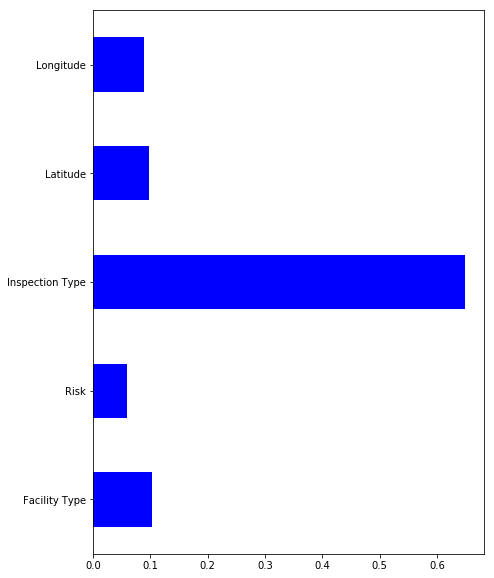

In [81]:
import matplotlib.pyplot as plt
FI = pd.Series(model_gbtree.feature_importances_, X.columns)
plt.figure(figsize=(7,10))
FI.plot.barh(color='blue');

In [0]:
!pip install eli5

In [89]:
import eli5
from eli5.sklearn import PermutationImportance

model_values=XGBClassifier(max_depth=4,n_estimators=135,n_jobs=-1,random_state=42)
model_values.fit(X.values,y.values)
permuter = PermutationImportance(model_values,scoring='roc_auc',cv='prefit',n_iter=2,random_state=42)

permuter.fit(X.values,y.values)

PermutationImportance(cv='prefit',
           estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=135,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
           n_iter=2, random_state=42, refit=True, scoring='roc_auc')

In [90]:
feature_names = X.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1798 ± 0.0002,Inspection Type
0.0425 ± 0.0005,Latitude
0.0410 ± 0.0002,Longitude
0.0157 ± 0.0013,Facility Type
0.0057 ± 0.0002,Risk


In [0]:
!pip install pdpbox

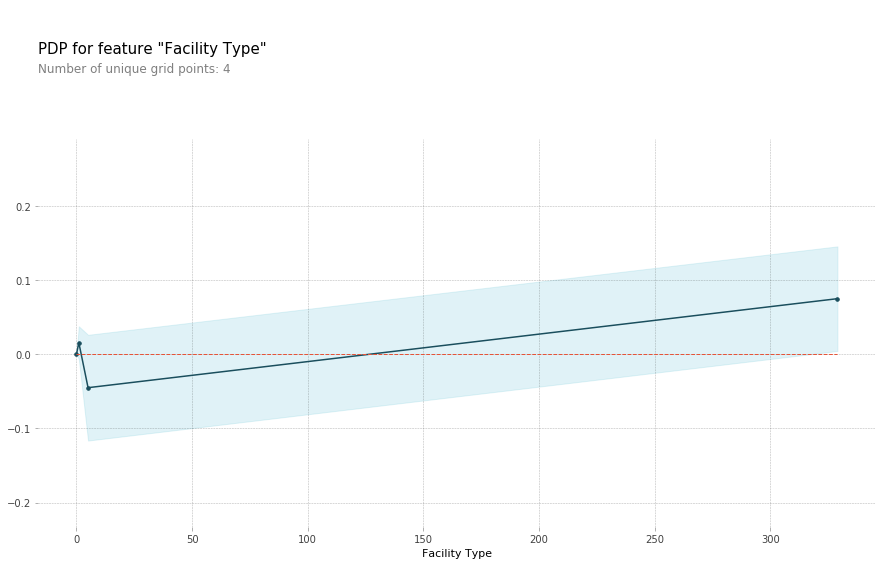

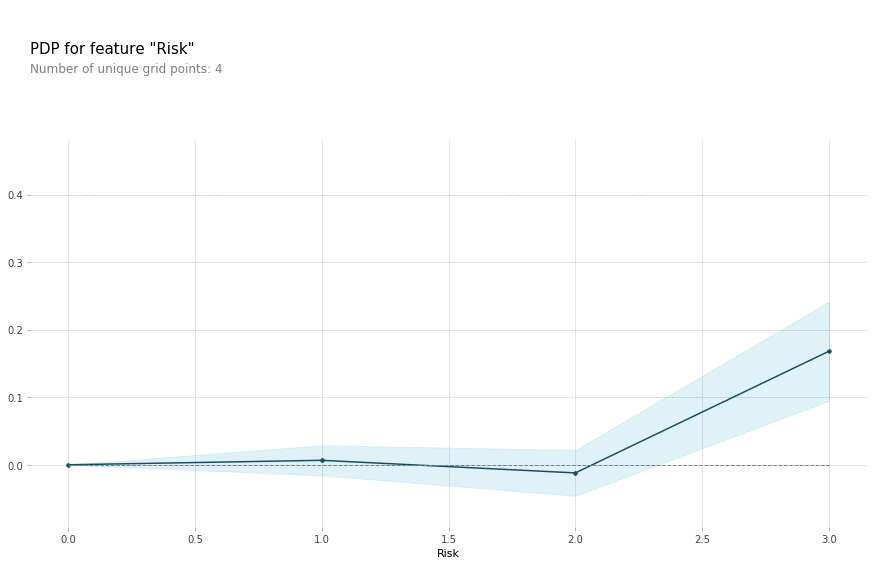

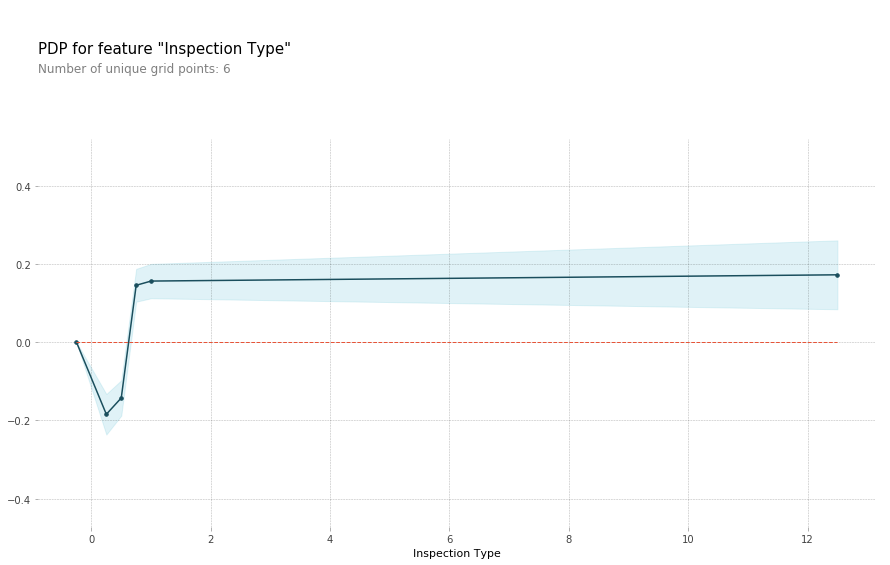

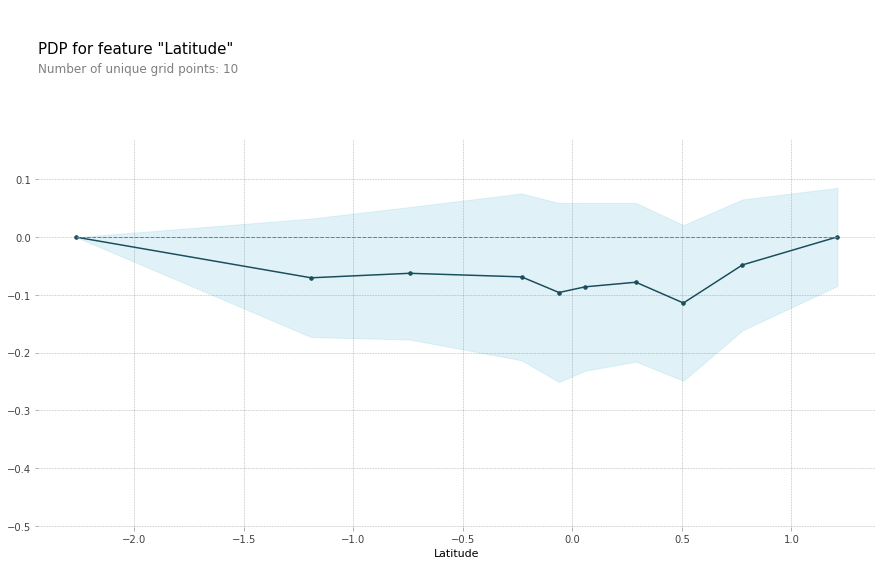

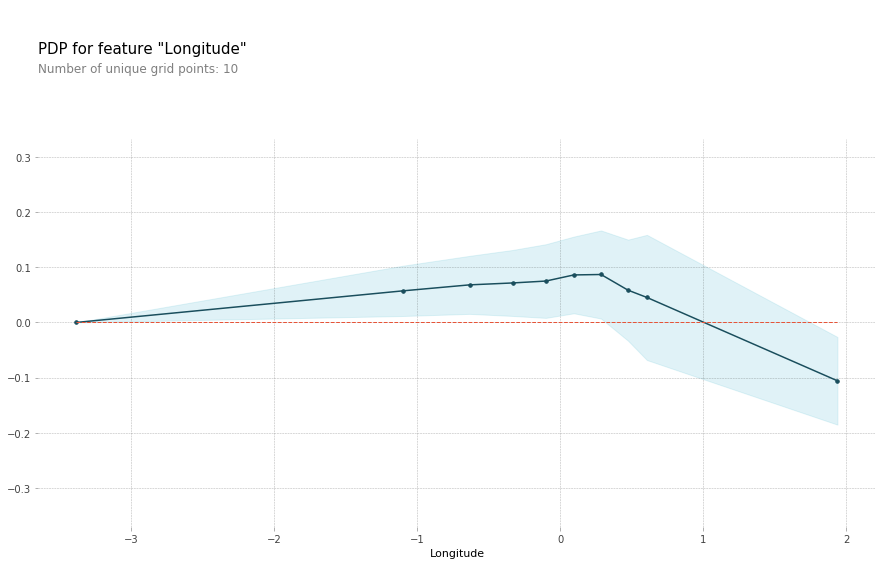

In [94]:
from pdpbox.pdp import pdp_isolate, pdp_plot

my_features = X.columns

for feature in my_features:
    isolated = pdp_isolate(
        model=model, 
        dataset=X, 
        model_features=X.columns, 
        feature=feature
    )

    pdp_plot(isolated, feature_name=feature);

In [0]:
!pip install shap

In [99]:
#finding some outliers
shap_copy=X.copy()
shap_copy['predicted_probs']=model.predict_proba(X)[:,1]
shap_copy['Fail']=y.copy()
shap_copy['proba_diff']=shap_copy['Fail']-shap_copy['predicted_probs']
shap_copy['proba_diff'].min(),shap_copy['proba_diff'].max()

(-0.7632278, 0.9558938)

In [100]:
shap_copy[shap_copy['proba_diff']<-0.763]

,Facility Type,Risk,Inspection Type,Latitude,Longitude,predicted_probs,Fail,proba_diff
13314,26.0,0.0,2.75,-1.2791,0.754138,0.763228,0,-0.763228


In [101]:
shap_copy[shap_copy['proba_diff']>0.955]

,Facility Type,Risk,Inspection Type,Latitude,Longitude,predicted_probs,Fail,proba_diff
18168,0.0,2.0,0.25,1.094079,-3.383371,0.044106,1,0.955894


In [105]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model_gbtree)

sample1=X.loc[13314].copy()
shap_values = explainer.shap_values(sample1)
shap.force_plot(explainer.expected_value, shap_values, sample1)

In [107]:
shap.initjs()
sample2=X.loc[18168].copy()
shap_values = explainer.shap_values(sample2)
shap.force_plot(explainer.expected_value, shap_values, sample2)

#Gradient Descent


1) Gradient descent is seekign to minimize the error function created by your model fit, by finding local minimums where the gradient is 0.  you do this by picking a random point and iterating at a certain rate outlined below towards this local minimum


2) the learning rate is what you multiply by the negative of your gradient at your current point on the curve before adjusting your current point to get your next point in your iteration.  if it is too low you take a long time to find your minimum/local minimum.  if it is too high you jump over the local minimum many times as you iterate.

In [109]:
#here is a gradient descent performed on a sin curve with interactive widget
import numpy as np
from ipywidgets import interact

def gradient_descent9(start_at=np.random.uniform(-1,1),iterations=20,learning_rate=0.1):
  
  xs=np.linspace(start=-5,stop=5)
  sinfunc=np.sin(xs)
  plt.plot(xs,sinfunc,color='c')
  plt.xlabel('x')  
  plt.ylabel('f(x)=sin(x)')
  
  x=start_at
  for _ in range(iterations):
    colors=['r','g','b','k','c','y']
    color_count=int(_%6)
    gradient=np.cos(x)
    x=x-learning_rate*gradient
    y=np.sin(x)
    plt.scatter(x,y,color=colors[color_count],edgecolor='k',zorder=3)
    tangent=np.cos(x)*xs+(np.sin(x)-np.cos(x)*x)
    plt.plot(xs,tangent,c=colors[color_count])
    
interact(gradient_descent9,start_at=(-1,1,0.1),iterations=(1,20,1),learning_rate=(0.05,0.96,0.05))

interactive(children=(FloatSlider(value=0.8129014543208166, description='start_at', max=1.0, min=-1.0), IntSli…

<function __main__.gradient_descent9>

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._